<a href="https://colab.research.google.com/github/rtaglega53/pedropicapiedra/blob/master/CPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Adding all the possible necessary libraries



In [2]:
# librerias para manejo de datos y graficas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import time
import warnings
# librerias para clustering
from sklearn import cluster, datasets, mixture, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
# librerias para busqueda de hiperparametros
from sklearn import metrics, preprocessing, tree
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier as dt
from sklearn.model_selection import KFold
# librerias para PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import svm, metrics
warnings.filterwarnings("ignore")

Adding the file

In [3]:
# no se necesita cargar todo el tiempo
uploaded = files.upload()
df = pd.read_csv('customer_allocation_complete.csv')
df.head()

Saving customer_allocation_complete.csv to customer_allocation_complete.csv


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Year,2021,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72,Unnamed: 73,Unnamed: 74
0,NaN,NaN,NaN,NaN,Month,P02,NaN,NaN,NaN,NaN,NaN,NaN,P03,NaN,NaN,NaN,NaN,NaN,NaN,P04,NaN,NaN,NaN,NaN,NaN,NaN,P05,NaN,NaN,NaN,NaN,NaN,NaN,P06,NaN,NaN,NaN,NaN,NaN,NaN,P02,NaN,P03,NaN,P04,NaN,P05,NaN,P06,NaN,P02,NaN,NaN,NaN,NaN,P03,NaN,NaN,NaN,NaN,P04,NaN,NaN,NaN,NaN,P05,NaN,NaN,NaN,NaN,P06,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,Metrics,FC-6,FC-5,FC-4,FC-3,FC-2,FC-1,DLY,FC-6,FC-5,FC-4,FC-3,FC-2,FC-1,DLY,FC-6,FC-5,FC-4,FC-3,FC-2,FC-1,DLY,FC-6,FC-5,FC-4,FC-3,FC-2,FC-1,DLY,FC-6,FC-5,FC-4,FC-3,FC-2,FC-1,DLY,Score,Cluster_id,Score,Cluster_id,Score,Cluster_id,Score,Cluster_id,Score,Cluster_id,Baseline Qty (score based),Baseline Qty (weighted average),Baseline Qty (Exponential smoothing 1),Baseline Qty (Exponential smoothing 2),Baseline Qty (Exponential smoothing 3),Baseline Qty (score based),Baseline Qty (weighted average),Baseline Qty (Exponential smoothing 1),Baseline Qty (Exponential smoothing 2),Baseline Qty (Exponential smoothing 3),Baseline Qty (score based),Baseline Qty (weighted average),Baseline Qty (Exponential smoothing 1),Baseline Qty (Exponential smoothing 2),Baseline Qty (Exponential smoothing 3),Baseline Qty (score based),Baseline Qty (weighted average),Baseline Qty (Exponential smoothing 1),Baseline Qty (Exponential smoothing 2),Baseline Qty (Exponential smoothing 3),Baseline Qty (score based),Baseline Qty (weighted average),Baseline Qty (Exponential smoothing 1),Baseline Qty (Exponential smoothing 2),Baseline Qty (Exponential smoothing 3)
2,MaterialNumber,Market,Country,CustomerFCGCode,CustomerFCGName,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7981020031,Market America,UNITED STATES,C4056,VERIZON WIRELINE-USA,336,0,0,0,0,0,0,336,252,210,0,42,42,42,378,378,420,420,0,84,84,336,420,378,378,378,0,0,378,462,462,420,378,378,378,NaN,17,-3.9,20,-11.6,21,NaN,21,20.7,21,0,0,0,0,0,42,13,42,43,162,84,8,80,88,397,0,0,52,91,373,378,424,379,381,449
4,600044-641-005,Market America,UNITED STATES,C4394,CENTURYLINK-USA,0,0,0,0,0,0,0,50,50,50,50,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,50,50,50,50,0,0,NaN,NaN,NaN,23,NaN,NaN,NaN,NaN,NaN,23,0,0,0,0,0,0,0,7,12,49,0,0,0,0,0,0,0,0,0,0,0,0,7,12,49


In [4]:
df_base = df.copy()
df = df_base.copy()

Clean the data and save months and cycles in a separated variables

In [83]:
# utilizamos metodo copy para poder jugar con los valors sin tener que cargar el archivo
df_copy = df.drop(columns=['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3']).copy()
df_copy = df_copy.drop(index=[2])
columns_names = df_copy.columns
df_copy.columns = df_copy.iloc[1]
df_copy = df_copy.drop(columns=['DLY'])
df_copy.columns.name = None
months = df_copy.iloc[0]
cycles = df_copy.iloc[1]
df_copy = df_copy.drop(index=[1])
df_copy.head()


,Metrics,FC-6,FC-5,FC-4,FC-3,FC-2,FC-1,FC-6,FC-5,FC-4,FC-3,FC-2,FC-1,FC-6,FC-5,FC-4,FC-3,FC-2,FC-1,FC-6,FC-5,FC-4,FC-3,FC-2,FC-1,FC-6,FC-5,FC-4,FC-3,FC-2,FC-1,Score,Cluster_id,Score,Cluster_id,Score,Cluster_id,Score,Cluster_id,Score,Cluster_id,Baseline Qty (score based),Baseline Qty (weighted average),Baseline Qty (Exponential smoothing 1),Baseline Qty (Exponential smoothing 2),Baseline Qty (Exponential smoothing 3),Baseline Qty (score based),Baseline Qty (weighted average),Baseline Qty (Exponential smoothing 1),Baseline Qty (Exponential smoothing 2),Baseline Qty (Exponential smoothing 3),Baseline Qty (score based),Baseline Qty (weighted average),Baseline Qty (Exponential smoothing 1),Baseline Qty (Exponential smoothing 2),Baseline Qty (Exponential smoothing 3),Baseline Qty (score based),Baseline Qty (weighted average),Baseline Qty (Exponential smoothing 1),Baseline Qty (Exponential smoothing 2),Baseline Qty (Exponential smoothing 3),Baseline Qty (score based),Baseline Qty (weighted average),Baseline Qty (Exponential smoothing 1),Baseline Qty (Exponential smoothing 2),Baseline Qty (Exponential smoothing 3)
0,Month,P02,NaN,NaN,NaN,NaN,NaN,P03,NaN,NaN,NaN,NaN,NaN,P04,NaN,NaN,NaN,NaN,NaN,P05,NaN,NaN,NaN,NaN,NaN,P06,NaN,NaN,NaN,NaN,NaN,P02,NaN,P03,NaN,P04,NaN,P05,NaN,P06,NaN,P02,NaN,NaN,NaN,NaN,P03,NaN,NaN,NaN,NaN,P04,NaN,NaN,NaN,NaN,P05,NaN,NaN,NaN,NaN,P06,NaN,NaN,NaN,NaN
3,VERIZON WIRELINE-USA,336,0,0,0,0,0,336,252,210,0,42,42,378,378,420,420,0,84,336,420,378,378,378,0,378,462,462,420,378,378,NaN,17,-3.9,20,-11.6,21,NaN,21,20.7,21,0,0,0,0,0,42,13,42,43,162,84,8,80,88,397,0,0,52,91,373,378,424,379,381,449
4,CENTURYLINK-USA,0,0,0,0,0,0,50,50,50,50,50,0,0,0,0,0,0,0,0,0,0,0,0,0,50,50,50,50,50,0,NaN,NaN,NaN,23,NaN,NaN,NaN,NaN,NaN,23,0,0,0,0,0,0,0,7,12,49,0,0,0,0,0,0,0,0,0,0,0,0,7,12,49
5,CENTURYLINK-USA,250,250,250,100,0,0,250,250,250,100,100,0,250,250,250,100,0,0,250,250,250,100,100,0,250,250,250,100,0,0,NaN,20,NaN,20,NaN,20,NaN,20,NaN,20,0,0,2,8,208,0,0,14,26,212,0,0,2,8,208,0,0,14,26,212,0,0,2,8,208
6,ORANGE-FRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,30,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,-3.9,7,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,9,29,28,2,0,0,0,0,0,0,0,0,0,0


data set is transposed and cleaned for the analysis


In [84]:
df_copy = df_copy.transpose()
df_copy.columns = df_copy.iloc[0]
df_copy = df_copy.drop(index=['Metrics'])
df_copy.head()



#df_copy.describe(include=np.object)

Metrics,Month,VERIZON WIRELINE-USA,CENTURYLINK-USA,CENTURYLINK-USA,ORANGE-FRA,ORANGE-ESP,VODAFONE-ESP,SWISSCOM-CHE,SINGTEL-PHL,DEUTSCHE TELEKOM-AUT,TDC-DNK,ORANGE-FRA,VODAFONE-ITA,TT-GO-MLT,EMEA NATIONAL SP-PRT,ORANGE-ESP,VODAFONE-ESP,VODAFONE-NZL,VEON-WIND-ITA,EMEA NATIONAL SP-PRT,Other Customers in NIGERIA,OOREDOO-OMN,SPRINT NEXTEL-USA,UTILITIES-USA,OTLE-USA,SHENTEL-USA,REGIONALS-USA,TMOBILE-USA,TMOBILE-USA,RAKUTEN-JPN,MTC-SAU,TELUS-CAN,VHA-AUS,VODAFONE-NZL,SINGTEL-PHL,IBG GCHN - DITO,CHUNGHWA TELECOM-TWN,ASIA PACIFIC TELECOM-TWN,FAR EASTONE TELECOM-TW,TAIWAN MOBILE-TWN,...,CHARTER-USA,Vinaphone-VNM,ORANGE-FRA,CNT-ECU,TELUS-CAN,UTILITIES-CAN,SASKTEL-CAN,COGECO ENTITY-CAN,UTILITIES-USA,REGIONALS-USA,NORTHWEST FIBER-USA,CINCINNATI BELL TELEPHONE COMPANY LLC.,HOTWIRE COMMUNICATIONS LTD,METRONET,BELL CANADA-CAN,GOV & CITIES-USA,OTLE-USA,Two Degrees-NZL,END CUSTOMERS HOTH IN SPAIN,VM PUBLIC SECTOR-INDIRECT-MEX,TRANSPORT&LOGISTICS OTH-FRA,GOV AND CITIES CHAN-FRA,OTHER LE-CHAN-DIST-FRA,GOV AND CITIES-CHAN-DIST-FRA,OTHER SERV. PROV.-AXIONE-FRA,Nuvias Deutschland-DEU,END CUSTOMERS TXLE IN TURKEY,ORANGE-FRA,GOVERNMENT AND CITIES-SGP,OTHER CUSTOMERS IN OMAN,END CUSTOMERS TXLE IN AUSTRALIA,GOVERNMENT AND CITIES-SGP,OTHER SERV. PROVIDERS-IDN,Bali Tower-IDN,END CUSTOMERS HOTH IN SPAIN,GOV AND CITIES-ESP,OTHER SERV. PROVIDERS-UKR,OTHER LE-CHAN-DEU,SP-CABLE-IND,TRANSPORTATION-BRA
FC-6,P02,336,0,250,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,500,0,2000,0,0,0,0,1000,0,0,0,0,0,...,10,0,0,0,8000,0,20,0,0,200,0,0,0,50,100,0,0,0,8,0,4,0,0,163,0,0,0,0,0,47,0,0,0,0,5,0,0,0,0,5
FC-5,NaN,0,0,250,0,0,0,0,0,0,0,0,0,0,0,0,0,800,0,0,0,0,200,0,0,0,500,500,0,2000,10000,0,0,0,1000,0,50,0,0,50,...,12,0,11,0,8000,0,20,0,0,200,0,0,0,50,100,0,0,0,0,120,4,0,0,0,0,0,0,0,0,47,0,0,0,0,0,0,0,0,0,0
FC-4,NaN,0,0,250,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,200,0,0,0,500,2352,0,0,10000,0,0,0,1000,0,0,0,0,0,...,2,0,11,0,7000,0,20,0,250,200,0,0,0,50,200,10,0,0,0,0,0,0,0,0,0,0,538,0,0,0,0,0,0,1,0,0,0,0,0,0
FC-3,NaN,0,0,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4000,0,0,0,0,0,0,2352,0,0,10000,0,0,0,100,0,0,0,0,0,...,0,0,11,20,11000,0,0,0,250,200,0,0,2500,50,200,10,12,0,0,0,0,0,0,0,0,0,538,6,0,0,0,0,0,0,0,0,37,0,0,0
FC-2,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4000,0,0,200,0,0,0,2352,0,0,8000,0,0,0,40,0,0,0,0,0,...,20,0,11,20,14000,265,0,0,0,0,0,0,2500,50,200,10,12,0,0,0,0,0,0,0,0,0,538,6,0,0,0,0,0,0,0,0,37,0,0,0


In [85]:
df_copy.tail()

Metrics,Month,VERIZON WIRELINE-USA,CENTURYLINK-USA,CENTURYLINK-USA,ORANGE-FRA,ORANGE-ESP,VODAFONE-ESP,SWISSCOM-CHE,SINGTEL-PHL,DEUTSCHE TELEKOM-AUT,TDC-DNK,ORANGE-FRA,VODAFONE-ITA,TT-GO-MLT,EMEA NATIONAL SP-PRT,ORANGE-ESP,VODAFONE-ESP,VODAFONE-NZL,VEON-WIND-ITA,EMEA NATIONAL SP-PRT,Other Customers in NIGERIA,OOREDOO-OMN,SPRINT NEXTEL-USA,UTILITIES-USA,OTLE-USA,SHENTEL-USA,REGIONALS-USA,TMOBILE-USA,TMOBILE-USA,RAKUTEN-JPN,MTC-SAU,TELUS-CAN,VHA-AUS,VODAFONE-NZL,SINGTEL-PHL,IBG GCHN - DITO,CHUNGHWA TELECOM-TWN,ASIA PACIFIC TELECOM-TWN,FAR EASTONE TELECOM-TW,TAIWAN MOBILE-TWN,...,CHARTER-USA,Vinaphone-VNM,ORANGE-FRA,CNT-ECU,TELUS-CAN,UTILITIES-CAN,SASKTEL-CAN,COGECO ENTITY-CAN,UTILITIES-USA,REGIONALS-USA,NORTHWEST FIBER-USA,CINCINNATI BELL TELEPHONE COMPANY LLC.,HOTWIRE COMMUNICATIONS LTD,METRONET,BELL CANADA-CAN,GOV & CITIES-USA,OTLE-USA,Two Degrees-NZL,END CUSTOMERS HOTH IN SPAIN,VM PUBLIC SECTOR-INDIRECT-MEX,TRANSPORT&LOGISTICS OTH-FRA,GOV AND CITIES CHAN-FRA,OTHER LE-CHAN-DIST-FRA,GOV AND CITIES-CHAN-DIST-FRA,OTHER SERV. PROV.-AXIONE-FRA,Nuvias Deutschland-DEU,END CUSTOMERS TXLE IN TURKEY,ORANGE-FRA,GOVERNMENT AND CITIES-SGP,OTHER CUSTOMERS IN OMAN,END CUSTOMERS TXLE IN AUSTRALIA,GOVERNMENT AND CITIES-SGP,OTHER SERV. PROVIDERS-IDN,Bali Tower-IDN,END CUSTOMERS HOTH IN SPAIN,GOV AND CITIES-ESP,OTHER SERV. PROVIDERS-UKR,OTHER LE-CHAN-DEU,SP-CABLE-IND,TRANSPORTATION-BRA
Baseline Qty (score based),P06,378,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,250,0,1080,500,0,0,0,0,0,1000,50,0,0,50,...,0,0,11,0,8756,300,0,0,12,200,0,250,111,50,12,1,4,0,4,0,0,0,0,121,433,114,0,0,106,0,0,0,0,0,0,0,0,0,0,0
Baseline Qty (weighted average),NaN,424,0,0,0,10,0,90,1,0,0,0,0,0,0,10,100,24,0,0,0,400,60,0,0,0,500,0,1296,1850,0,0,0,0,0,100,50,0,0,50,...,0,0,11,0,8200,300,0,0,22,200,0,250,1575,50,170,1,9,0,1,0,0,0,0,13,46,12,0,0,106,0,0,0,0,0,0,0,0,0,0,0
Baseline Qty (Exponential smoothing 1),NaN,379,7,2,0,86,0,294,12,0,0,0,0,0,0,86,862,207,0,0,0,3448,196,24,0,0,4311,318,2154,469,0,0,11,357,119,862,50,0,7,50,...,0,0,11,0,11564,300,0,0,194,200,0,250,2739,50,286,9,78,0,7,0,0,63,0,109,393,103,1,0,106,0,0,0,0,0,0,0,0,0,0,0
Baseline Qty (Exponential smoothing 2),NaN,381,12,8,0,76,0,283,11,0,0,0,0,0,0,76,759,182,0,0,0,3034,188,37,0,0,3799,536,2130,496,0,0,53,549,183,759,50,1,12,50,...,0,0,11,0,11203,300,0,0,171,200,0,250,2700,50,274,8,68,0,6,0,0,109,0,96,346,91,6,0,106,0,0,0,0,0,0,0,0,0,0,0
Baseline Qty (Exponential smoothing 3),NaN,449,49,208,0,1,0,17,0,0,0,0,0,0,0,1,14,3,0,0,0,56,12,9,0,0,450,535,522,1890,0,0,3793,133,44,14,50,38,49,50,...,8,0,11,0,7342,300,0,0,3,200,0,250,618,50,126,0,1,0,0,0,3,450,0,2,6,2,319,0,106,0,0,0,0,0,0,0,0,0,0,0


Declare month of the quarter, this information is needed to sort the right months 

In [86]:
months_range = ['CM', '+1M', '+2M', '+3M', '+4M']
month_base = 0
# print(len(months_range), month_base)
df_copy.shape
# df_copy.info()
df_copy.describe(include=np.object)

Metrics,Month,VERIZON WIRELINE-USA,CENTURYLINK-USA,CENTURYLINK-USA,ORANGE-FRA,ORANGE-ESP,VODAFONE-ESP,SWISSCOM-CHE,SINGTEL-PHL,DEUTSCHE TELEKOM-AUT,TDC-DNK,ORANGE-FRA,VODAFONE-ITA,TT-GO-MLT,EMEA NATIONAL SP-PRT,ORANGE-ESP,VODAFONE-ESP,VODAFONE-NZL,VEON-WIND-ITA,EMEA NATIONAL SP-PRT,Other Customers in NIGERIA,OOREDOO-OMN,SPRINT NEXTEL-USA,UTILITIES-USA,OTLE-USA,SHENTEL-USA,REGIONALS-USA,TMOBILE-USA,TMOBILE-USA,RAKUTEN-JPN,MTC-SAU,TELUS-CAN,VHA-AUS,VODAFONE-NZL,SINGTEL-PHL,IBG GCHN - DITO,CHUNGHWA TELECOM-TWN,ASIA PACIFIC TELECOM-TWN,FAR EASTONE TELECOM-TW,TAIWAN MOBILE-TWN,...,CHARTER-USA,Vinaphone-VNM,ORANGE-FRA,CNT-ECU,TELUS-CAN,UTILITIES-CAN,SASKTEL-CAN,COGECO ENTITY-CAN,UTILITIES-USA,REGIONALS-USA,NORTHWEST FIBER-USA,CINCINNATI BELL TELEPHONE COMPANY LLC.,HOTWIRE COMMUNICATIONS LTD,METRONET,BELL CANADA-CAN,GOV & CITIES-USA,OTLE-USA,Two Degrees-NZL,END CUSTOMERS HOTH IN SPAIN,VM PUBLIC SECTOR-INDIRECT-MEX,TRANSPORT&LOGISTICS OTH-FRA,GOV AND CITIES CHAN-FRA,OTHER LE-CHAN-DIST-FRA,GOV AND CITIES-CHAN-DIST-FRA,OTHER SERV. PROV.-AXIONE-FRA,Nuvias Deutschland-DEU,END CUSTOMERS TXLE IN TURKEY,ORANGE-FRA,GOVERNMENT AND CITIES-SGP,OTHER CUSTOMERS IN OMAN,END CUSTOMERS TXLE IN AUSTRALIA,GOVERNMENT AND CITIES-SGP,OTHER SERV. PROVIDERS-IDN,Bali Tower-IDN,END CUSTOMERS HOTH IN SPAIN,GOV AND CITIES-ESP,OTHER SERV. PROVIDERS-UKR,OTHER LE-CHAN-DEU,SP-CABLE-IND,TRANSPORTATION-BRA
count,15,63,57,60,57,57,57,61,57,57,56,57,61,57,59,57,61,65,56,59,60,59,59,61,57,56,65,63,57,63,61,57,59,57,58,57,59,57,57,59,...,62,57,61,57,64,61,60,57,62,62,57,60,63,63,65,65,65,57,59,58,57,57,56,60,57,59,61,57,59,57,57,57,56,60,56,56,61,63,57,57
unique,5,29,6,10,8,8,4,17,7,7,2,8,17,5,10,8,14,25,5,10,18,14,14,19,8,2,35,29,9,25,23,7,6,10,16,8,8,7,9,9,...,16,7,10,7,39,20,11,5,21,12,7,14,27,8,22,9,14,7,11,5,5,8,3,19,9,14,22,6,9,6,7,4,2,9,3,4,18,4,7,4
top,P04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,7000,0,0,0,0,200,0,0,0,50,200,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
freq,3,15,39,18,49,50,52,37,51,51,55,49,37,52,47,50,42,24,50,46,37,44,40,34,49,55,14,18,47,19,21,48,39,46,37,49,39,50,47,39,...,23,47,25,47,13,26,32,46,27,35,49,30,22,43,14,35,25,51,42,46,51,46,54,38,49,43,32,47,34,50,51,44,55,46,54,48,34,42,50,52


Algorithm to group data by quarter



In [87]:

months = df_copy['Month']
month_base = (len(months_range) - 3) * 6
df_copy = df_copy.drop(columns=['Month'])
df_copy.columns.name = None
first_quarter = df_copy.iloc[0:month_base]  # first quarter
second_quarter = df_copy.iloc[month_base:month_base+18]  # secondo quarter, 18 because are always 3 months
first_quarter =first_quarter.transpose()
first_quarter
  


,FC-6,FC-5,FC-4,FC-3,FC-2,FC-1,FC-6,FC-5,FC-4,FC-3,FC-2,FC-1
VERIZON WIRELINE-USA,336,0,0,0,0,0,336,252,210,0,42,42
CENTURYLINK-USA,0,0,0,0,0,0,50,50,50,50,50,0
CENTURYLINK-USA,250,250,250,100,0,0,250,250,250,100,100,0
ORANGE-FRA,0,0,0,0,0,0,0,0,0,0,0,0
ORANGE-ESP,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
GOV AND CITIES-ESP,0,0,0,0,0,0,0,0,0,0,0,0
OTHER SERV. PROVIDERS-UKR,0,0,0,37,37,13,0,0,0,0,0,0
OTHER LE-CHAN-DEU,0,0,0,0,0,1,0,0,0,0,0,1
SP-CABLE-IND,0,0,0,0,0,11,0,0,0,0,0,0


2nd quarter tail

In [88]:
second_quarter = second_quarter.transpose()
second_quarter

,FC-6,FC-5,FC-4,FC-3,FC-2,FC-1,FC-6,FC-5,FC-4,FC-3,FC-2,FC-1,FC-6,FC-5,FC-4,FC-3,FC-2,FC-1
VERIZON WIRELINE-USA,378,378,420,420,0,84,336,420,378,378,378,0,378,462,462,420,378,378
CENTURYLINK-USA,0,0,0,0,0,0,0,0,0,0,0,0,50,50,50,50,50,0
CENTURYLINK-USA,250,250,250,100,0,0,250,250,250,100,100,0,250,250,250,100,0,0
ORANGE-FRA,0,0,0,0,30,30,0,0,0,0,0,0,0,0,0,0,0,0
ORANGE-ESP,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GOV AND CITIES-ESP,0,0,0,0,0,0,0,5,5,5,5,0,0,0,0,0,0,0
OTHER SERV. PROVIDERS-UKR,0,0,0,20,20,22,0,0,0,0,0,20,0,0,0,0,0,0
OTHER LE-CHAN-DEU,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
SP-CABLE-IND,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


12
[0 0 0 ... 0 0 0]
[['336' '0' '0' ... '0' '42' '42']
 ['0' '0' '0' ... '50' '50' '0']
 ['250' '250' '250' ... '100' '100' '0']
 ...
 ['0' '0' '0' ... '0' '0' '1']
 ['0' '0' '0' ... '0' '0' '0']
 ['5' '0' '0' ... '0' '0' '0']]
['336' '0' '250' ... '0' '0' '5']


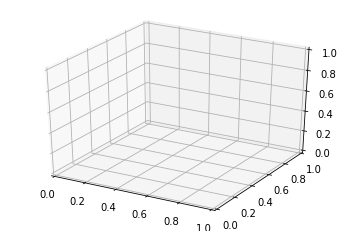

In [102]:
x = np.asanyarray(first_quarter)
print (len(x[0]))
kmeans = cluster.KMeans(n_clusters = 22, random_state = 0)
kmeans.fit(x)
labels = kmeans.predict(x)
print(labels)
print(x)
print(x[:,0])

fig = plt.figure() 
# ax = plt.subplot(2, 2, 1)
ax = fig.add_subplot(111, projection='3d')
# print(x)
#ax.scatter(x[:,0], x[:,1],  x[:,2],)



def kmeans_silhouette(data, n_clusters):
  
  clusterer = cluster.KMeans(n_clusters=n_clusters)
  cluster_labels = clusterer.fit_predict(data)
  silhouette_avg = silhouette_score(data, cluster_labels)
  print("For n_clusters =", n_clusters,
  "The average Kmean_silhouette_score is :", silhouette_avg)
  sample_silhouette_values = silhouette_samples(data, cluster_labels)
  return silhouette_avg

In [103]:
model = TSNE(n_components=3, n_iter=2000, n_jobs=-1)
x_2d = model.fit_transform(x)
x_2d.shape

(6733, 3)

GRaficas

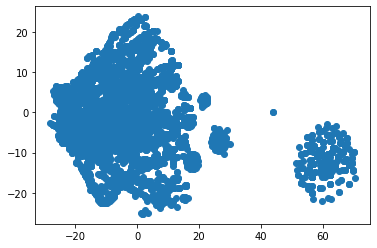

In [104]:
plt.scatter(x_2d[:,0],x_2d[:,1],  cmap=plt.cm.tab10)

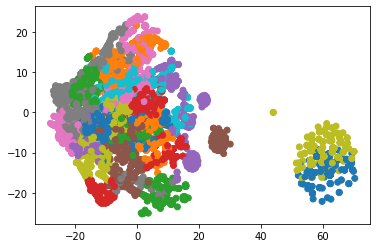

In [106]:
kmeans = cluster.KMeans(n_clusters = 30, random_state = 0)
kmeans.fit(x_2d)
labels = kmeans.predict(x_2d)
plt.scatter(x_2d[:,0],x_2d[:,1],c=labels,  cmap=plt.cm.tab10)

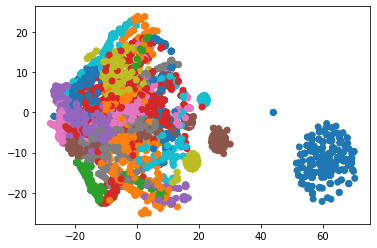

In [108]:
kmeans = mixture.GaussianMixture(n_components=30, covariance_type='full')
kmeans.fit(x_2d)
labels = kmeans.predict(x_2d)
plt.scatter(x_2d[:,0],x_2d[:,1],c=labels,  cmap=plt.cm.tab10)

For n_clusters = 5 The average Kmean_silhouette_score is : 0.9795380609680122
For n_clusters = 10 The average Kmean_silhouette_score is : 0.9700075025964041
For n_clusters = 20 The average Kmean_silhouette_score is : 0.9493553370528882
For n_clusters = 30 The average Kmean_silhouette_score is : 0.9195851259081657
For n_clusters = 40 The average Kmean_silhouette_score is : 0.9030656946987942


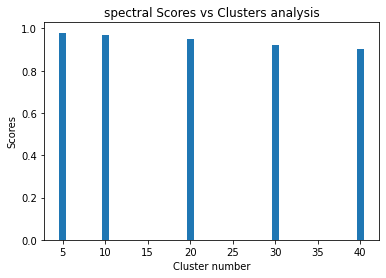

In [109]:
scores = []
classes = [5,10,20,30,40]
for each in classes:
  sil = kmeans_silhouette(x,each)
  scores.append(sil)
plt.xlabel("Cluster number")
plt.ylabel("Scores")
plt.title("spectral Scores vs Clusters analysis")
plt.bar(classes,scores)
scores = []
classes = [2,4,5,8,10]
plt.xlabel("Cluster number")
plt.ylabel("Scores")
plt.title("spectral Scores vs Clusters analysis")
plt.show()

In [110]:
scores = []
classes = [1000,5000,10000]
for each in classes:
  sil = kmeans_silhouette(x_2d,each)
  scores.append(sil)
plt.xlabel("Cluster number")
plt.ylabel("Scores")
plt.title("spectral Scores vs Clusters analysis")
plt.bar(classes,scores)
scores = []
classes = [2,4,5,8,10]
plt.xlabel("Cluster number")
plt.ylabel("Scores")
plt.title("spectral Scores vs Clusters analysis")
plt.show()

For n_clusters = 1000 The average Kmean_silhouette_score is : 0.6434141
For n_clusters = 5000 The average Kmean_silhouette_score is : 0.3424834


ValueError: ignored

In [111]:
from sklearn.metrics import silhouette_samples, silhouette_score

def calculate_silhouette(data, n_clusters, type):
  plt.figure
  plt.xlim([-0.1, 1])
  if type == 'KMeans':
    clusterer = cluster.KMeans(n_clusters=n_clusters, random_state = 0 )
  elif type == 'SpectralClustering':
    clusterer = cluster.SpectralClustering(n_clusters=n_clusters, affinity="nearest_neighbors")
  elif type == 'GaussianMixture':
    clusterer = mixture.GaussianMixture(n_components=n_clusters, covariance_type='full')
  elif type == 'OPTICS':
     clusterer = cluster.OPTICS(min_samples=20, xi=0.05, min_cluster_size=0.1)

  cluster_labels = clusterer.fit_predict(data)
  silhouette_avg = silhouette_score(data, cluster_labels)
  print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

  sample_silhouette_values = silhouette_samples(data, cluster_labels)

  y_lower = 10
  for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
    sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / n_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
  plt.show()